In [2]:
import cv2
import skimage.io as io
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
from skimage.exposure import histogram
from matplotlib.pyplot import bar
from skimage.color import rgb2gray,rgb2hsv

# Convolution:
from scipy.signal import convolve2d
from scipy import fftpack
import math

from skimage.util import random_noise
from skimage.filters import median, gaussian
from skimage.feature import canny

# Edges
from skimage.filters import sobel_h, sobel, sobel_v,roberts, prewitt

from skimage.morphology import dilation, square
from skimage import morphology
from ipywidgets import interact, fixed, IntSlider, FloatSlider


In [3]:
from Functions.hough_transform_module import Hough
from Functions.preprocessing_functions import ROI, smooth, gray_to_binary, apply_errosion

If importing error occurs, uncomment the following cell and run it

In [4]:
#pip install ipywidgets

## Read video

In [5]:
# read the first frame of the video and store it
vidcap = cv2.VideoCapture('images/LaneVideo.mp4')
success, frame = vidcap.read()

In [6]:
def plot_images(img1, img2, label1, label2):
    """Plots two images side by side."""
    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot the first image on the first subplot
    axes[0].imshow(img1, cmap='gray')
    axes[0].set_title(label1)

    # Plot the second image on the second subplot
    axes[1].imshow(img2, cmap='gray')
    axes[1].set_title(label2)

    # Show the plot
    plt.tight_layout()
    plt.show()

## Crop Image

In [7]:
# Crop image function 
cropped_img = None
x1, x2, y1, y2 = 0, 0, 0, 0

def ROI_test(img, x_start, x_end, y_start, y_end):
#   img = io.imread(path)
    global cropped_img, x1, x2, y1, y2
    x1, x2, y1, y2 = x_start, x_end, y_start, y_end
    cropped_img = img[y_start : y_end, x_start : x_end]
    plot_images(img, cropped_img, "Original Image", "Cropped Image")


In [8]:
H, W, _ = frame.shape

# Define sliders for the parameters
x_start_slider = IntSlider(min=0, max=W, step=5, value=200, description='x start:')
x_end_slider = IntSlider(min=0, max=W, step=5, value=1020, description='x end:')
y_start_slider = IntSlider(min=0, max=H, step=5, value=415, description='y start:')
y_end_slider = IntSlider(min=0, max=H, step=5, value=720, description='y end:')

# Create the interactive widget
interact(ROI_test, img=fixed(frame), 
         x_start=x_start_slider, y_start=y_start_slider,
         x_end=x_end_slider, y_end=y_end_slider)


interactive(children=(IntSlider(value=200, description='x start:', max=1280, step=5), IntSlider(value=1020, de…

<function __main__.ROI_test(img, x_start, x_end, y_start, y_end)>

## Convert img to Gray & Smoothing

In [9]:
def smooth(image):
    """Applies median filter to smooth image."""
    gray_image = rgb2gray(image)
    f_image = median(gray_image)
    return f_image

In [10]:
smoothed_img = smooth(cropped_img)

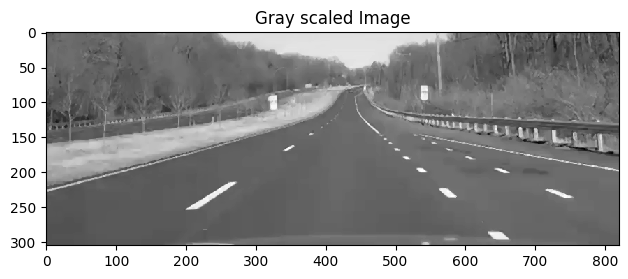

In [11]:
io.imshow(smoothed_img)
plt.title("Gray scaled Image")
plt.show()

## Prespective Transformation

In [12]:
def perspective_transformation(img):
    """Returns perspective transformation of an image."""
    H, W = img.shape
    
    # Define source points, points are defined as (col, row)
    d_top_left = (0, 0)
    d_top_right = (W-1, 0)
    d_bottom_left = (0, H - 1)
    d_bottom_right = (W - 1, H - 1)
    
    pts_destination = np.array([d_top_left, d_top_right, d_bottom_right, d_bottom_left], dtype=np.float32)
    
    # Define destination points
    s_top_left = (280, 150)
    s_top_right = (540, 150)
    s_bottom_left = (80, H - 30)
    s_bottom_right = (W -80, H - 40)
    pts_source = np.array([s_top_left, s_top_right, s_bottom_right, s_bottom_left], dtype=np.float32)
    
    # Get perspective transformation matrix
    matrix = cv2.getPerspectiveTransform(pts_source, pts_destination)
    
    # Apply perspective transformation
    result = cv2.warpPerspective(img, matrix, (W, H))
    
    return result, matrix, pts_source


In [13]:
transformed_img, PT_matrix, pts_source = perspective_transformation(smoothed_img)

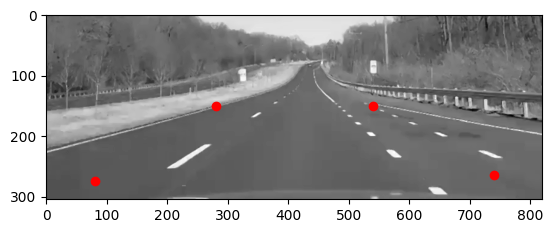

In [14]:
x, y = zip(*pts_source)
x, y = list(x), list(y)
plt.imshow(smoothed_img, cmap='gray')
plt.scatter(x, y, c='red')

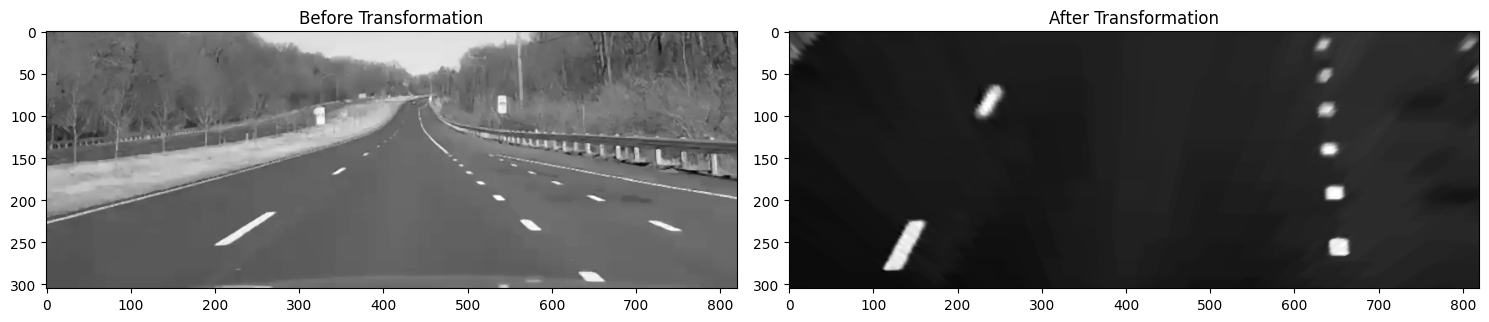

In [15]:
plot_images(smoothed_img, transformed_img, "Before Transformation", "After Transformation")

## Edge Detection (Thresholding | Canny)

In [16]:
def plot_hist(img, title=""):
    x = plt.hist(img.reshape(-1), bins=256, color='red')
    plt.title(title + " Histogram")
    plt.show()

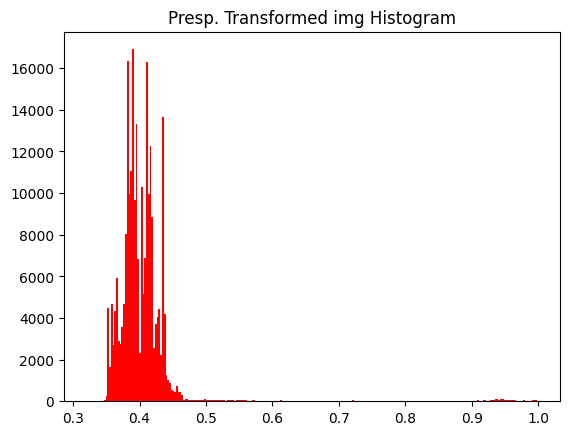

In [17]:
plot_hist(transformed_img, "Presp. Transformed img")

In [18]:
# Apply Canny edge detection with adjustable parameters
canny_edges_result = None
def apply_canny(img, sigma, low_threshold, high_threshold):
    global canny_edges_result
    canny_edges_result = canny(img, sigma=sigma, low_threshold=low_threshold, high_threshold=high_threshold)
    
    # Display the edge image
    plt.figure(figsize=(6, 6))
    plt.imshow(canny_edges_result, cmap='gray')
    plt.title(f'Canny Edges (Sigma={sigma}, Low={low_threshold}, High={high_threshold})')
    plt.axis('off')
    plt.show()
    
    

In [19]:
# Define sliders for the parameters
sigma_slider = FloatSlider(min=1, max=5.0, step=0.2, value=1.1, description='Sigma:')
low_threshold_slider = FloatSlider(min=0.1, max=1.0, step=0.05, value=0.15, description='Low Threshold:')
high_threshold_slider = FloatSlider(min=0.1, max=1.0, step=0.05, value=0.2, description='High Threshold:')

# Create the interactive widget
interact(apply_canny, img=fixed(transformed_img), 
         sigma=sigma_slider, low_threshold=low_threshold_slider,
         high_threshold=high_threshold_slider)


interactive(children=(FloatSlider(value=1.1, description='Sigma:', max=5.0, min=1.0, step=0.2), FloatSlider(va…

<function __main__.apply_canny(img, sigma, low_threshold, high_threshold)>

In [20]:
binary_img = None
def gray_to_binary_test(img, threshold):
    """converts a gray scaled image to binary."""
    global binary_img
    binary_img = np.where(img > threshold, 1, 0)
    
    # Display image
    plt.figure(figsize=(6, 6))
    plt.imshow(binary_img, cmap='gray')
    plt.title(f'Binary Threshold = {threshold}')
    plt.axis('off')
    plt.show()

In [21]:
# Define sliders for the parameters
threshold_slider = FloatSlider(min=0, max=1, step=0.01, value=0.61, description='Threshold:')

# Create the interactive widget
interact(gray_to_binary_test, img=fixed(transformed_img), threshold=threshold_slider)


interactive(children=(FloatSlider(value=0.61, description='Threshold:', max=1.0, step=0.01), Output()), _dom_c…

<function __main__.gray_to_binary_test(img, threshold)>

Best Threshold is 0.5 for this frame

# Morphological operation

In [47]:
opened_img = None
def apply_erosion_test(img, element_size):
    """Applies opening morphological operation."""
    global opened_img
    
    element = morphology.rectangle(element_size, element_size+10)
    element2 = morphology.rectangle(element_size + 10, element_size)
   
    # Performing dilation and erosion separately
    dilated_img = morphology.dilation(img, element)
    eroded_img = morphology.erosion(dilated_img, element2) 
    
    # Display the opened image
    plt.figure(figsize=(6, 6))
    plt.imshow(eroded_img, cmap='gray')
    plt.title(f'Morphological Opening (Element Size: {element_size})')
    plt.show()

    opened_img = eroded_img



# Create a slider for the element size parameter
element_size_slider = IntSlider(min=1, max=50, step=1, value=1, description='Element Size')

# Create the interactive widget
interact(apply_erosion_test, img=fixed(binary_img), element_size=element_size_slider);    

interactive(children=(IntSlider(value=1, description='Element Size', max=50, min=1), Output()), _dom_classes=(…

# Hough Transform

In [23]:
hough_ = Hough(5, 200)

In [48]:
r1, theta1, r2, theta2 = hough_.get_polar_coorindates(opened_img)
lane1_mask = hough_.get_mask(opened_img, r1, theta1)
lane2_mask = hough_.get_mask(opened_img, r2, theta2)
lanes_mask = np.maximum(lane1_mask, lane2_mask)
print(r1,r2)

275 0


# Inverse Perspective Transformation

In [25]:
def inv_perspective_transform(inv_frame, t_matrix, W, H):
    """Applies Inverse Perspective Transformation on a transformed frame."""
    inv_t_matrix= np.linalg.inv(t_matrix)
    frame = cv2.warpPerspective(inv_frame, inv_t_matrix, (W, H))
    return frame

In [49]:
H, W, _ = lanes_mask.shape
inv_lanes_mask = inv_perspective_transform(lanes_mask, PT_matrix, W, H)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


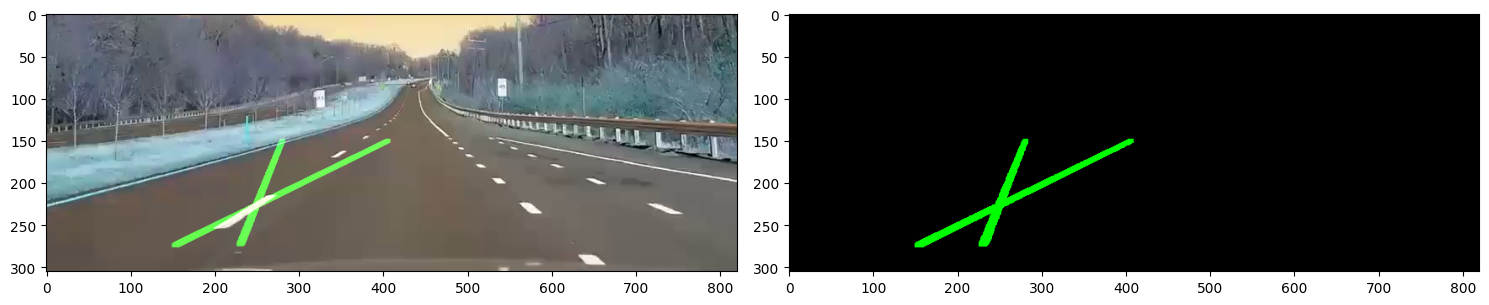

In [50]:
inv_lanes_mask[:, :, 1] = dilation(inv_lanes_mask[:, :, 1], square(5))
        
cropped_img[:, :, 1] = np.maximum(cropped_img[:, :, 1], inv_lanes_mask[:, :, 1])
plot_images(cropped_img, inv_lanes_mask, "", "")

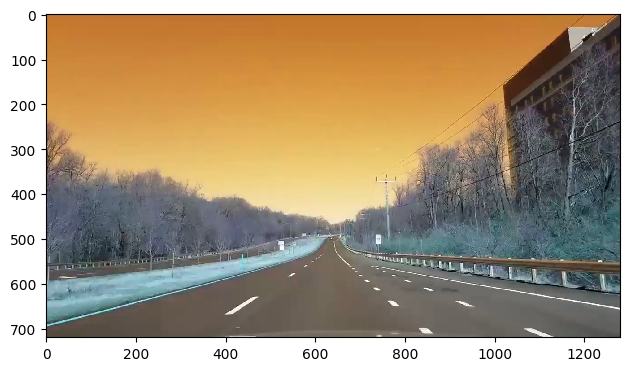

In [45]:
# original image
frame[y1:y2, x1:x2] = cropped_img
io.imshow(frame)

# PipeLine

In [28]:
def calc_distance_between_lines(r1, theta1, r2, theta2):
    """calculates distance between two lines given their r and theta in 
        polar coordinates.
    """
    dist = np.abs(r1 - r2 * np.cos(theta1 - theta2))
    return dist
    

In [29]:
distances1 = []
distances2 = []
approved1 = []
approved2 = []
def pipeline(video_path):
    video = cv2.VideoCapture('images/LaneVideo.mp4')
    i = 0

    past_r1, past_r2, past_theta1, past_theta2 = 0, 0, 0, 0
    while video.isOpened():
        ret, frame = video.read()
        if not ret:
            break
        
        # crop image using the following dimensions 
        cropped_img = ROI(frame, x1, x2, y1, y2)
        if(i % 1 == 0):
            # smooth image
            # smoothed_img = smooth(cropped_img)
            smoothed_img = rgb2gray(cropped_img)
            
            # apply Prespective transformation
            transformed_img, PT_matrix, pts_source = perspective_transformation(smoothed_img)
            
            # convert to binary
            threshold = 0.65
            binary_img = gray_to_binary(transformed_img, threshold)
            
            # add morphological opeations if needed
            morph_img = apply_errosion(binary_img, 2)
            
            # apply hough transfomration
            hough_ = Hough(5, 500)
            r1, theta1, r2, theta2 = hough_.get_polar_coorindates(morph_img)

            # calculate distance between new and previous r and theta
            dist1 = calc_distance_between_lines(r1, theta1, past_r1, past_theta1)
            dist2 = calc_distance_between_lines(r2, theta2, past_r2, past_theta2)

            distances1.append(dist1)
            distances2.append(dist2)
                        
            # check if the new line near to the previous one or if it is the first iteration
            if(dist1 < 200 or not (past_r1 and past_theta1)):
                lane1_mask = hough_.get_mask(morph_img, r1, theta1)
                approved1.append(dist1)
                past_r1, past_theta1 = r1, theta1
            else:
                approved1.append(0)

                
            if(dist2 < 200 or not (past_r2 and past_theta2)):
                lane2_mask = hough_.get_mask(morph_img, r2, theta2)
                approved2.append(dist2)
                past_r2, past_theta2 = r2, theta2
            else:
                approved2.append(0)
                
            lanes_mask = np.maximum(lane1_mask, lane2_mask)
            # apply inverse tranformation
            H, W, _ = lanes_mask.shape
            inv_lanes_mask = inv_perspective_transform(lanes_mask, PT_matrix, W, H)
        
            # add mask to the original frame
            inv_lanes_mask[:, :, 1] = dilation(inv_lanes_mask[:, :, 1], square(5)) # dilation   
        
            # # update past values
            # past_r1, past_r2, past_theta1, past_theta2 = r1, r2, theta1, theta2

        cropped_img[:, :, 1] = np.maximum(cropped_img[:, :, 1], inv_lanes_mask[:, :, 1])
        frame[y1:y2, x1:x2] = cropped_img

        i += 1
        
        # Display the frame
        cv2.imshow('Video Player', frame)
        cv2.imshow("PT", morph_img.astype(float))
        # Check for user input to exit (press 'q')
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break

    # Release resources
    video.release()
    cv2.destroyAllWindows()

In [ ]:
%time pipeline('images/LaneVideo.mp4')

KeyboardInterrupt: 

: 

<BarContainer object of 0 artists>

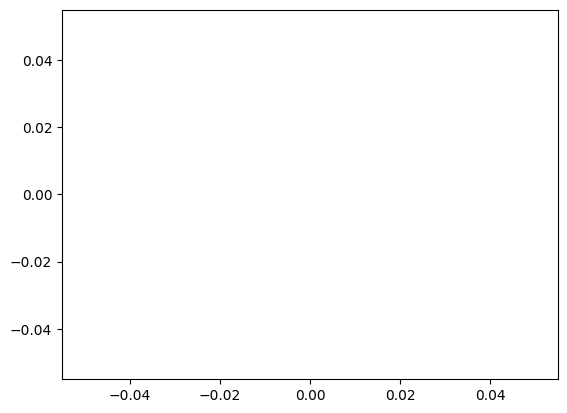

In [30]:
plt.bar(range(len(distances1)), distances1)
plt.bar(range(len(distances1)), approved1)


<BarContainer object of 0 artists>

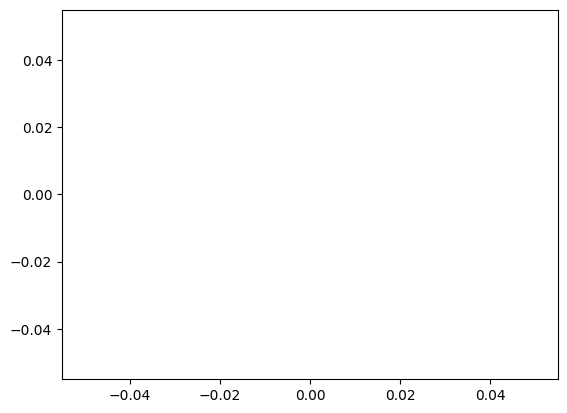

In [31]:
plt.bar(range(len(distances2)), distances2)
plt.bar(range(len(distances2)), approved2)

# Get the Lanes x-coordinates

In [51]:
def Get_lanes_bases(img):

    # Get the Histogram of the bottom half of the frame captured
    half_frame = img.shape[0] //2

    crop_half_frame = img[half_frame:,:]
    axis_Histogram = np.sum(crop_half_frame,axis = 0)

    # Get where is the max values located on the x-axis
    left_lane = np.argmax(axis_Histogram[:img.shape[1]//2])
    right_lane = (img.shape[1]//2) + np.argmax(axis_Histogram[img.shape[1]//2:]) 

    return left_lane, right_lane


137 645


(array([247055.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,   3045.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

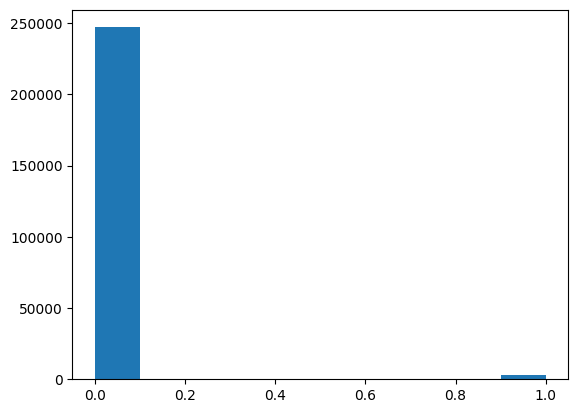

In [52]:
left, right = Get_lanes_bases(opened_img)
print(left, right)
plt.hist(opened_img.astype(int).reshape(-1))


# Sliding window

In [56]:
def sliding_window(img, imgHeight, left_lane, right_lane, window_height, window_width):
    
    # Arrays to hold the lane index
    x_left = []
    x_right = []

    left_y = []
    right_y = []
    
    # Creating the window on the lanes bases
    num_of_windows = imgHeight//window_height
    
    # Move the window on the lane
    for i in range(num_of_windows):
    
        left_lane_win = img[imgHeight -(i+1)*window_height:imgHeight - i*window_height, int(left_lane) - window_width//2:int(left_lane) + window_width//2]
        right_lane_win = img[imgHeight -(i+1)*window_height:imgHeight - i*window_height, int(right_lane) - window_width//2:int(right_lane) + window_width//2]


        # get the white pixels in the left and right window
        left_non_zero = np.argwhere(left_lane_win > 0)
        right_non_zero = np.argwhere(right_lane_win > 0)

        # Check if the window has no lane pixels
        if not ((left_non_zero.any() > 0) and (right_non_zero.any() > 0)):
            continue
        # add the index to the lane arrays
        left_new_index = left_non_zero[:,1] + max(0,(left_lane - window_width//2))
        right_new_index = right_non_zero[:,1] + max(0,(right_lane - window_width//2))

        # Lanes Y index
        left_y.append(imgHeight - i*window_height)
        right_y.append(imgHeight - i*window_height)

        # update the window base
        left_lane = np.mean(left_new_index)
        right_lane = np.mean(right_new_index)

        x_left.append(left_lane)
        x_right.append(right_lane)

    # meter to pixel 
    meter_pixel = 10 / 350     # Assume 30 meters in 720 pixels

    # Curve fitting(2nd degree poynomial) for the points from the window
    left_curve = np.polyfit(x_left, np.array(left_y)*meter_pixel, 2)
    right_curve = np.polyfit(x_right, np.array(right_y)*meter_pixel, 2)

    return left_curve, right_curve


# Get Curvature

In [54]:
def get_Curvature(left_curve, right_curve, y_value, meter_pixel = 10/350 ):

    # polynomial fitting = Ax^2 + Bx + C
    A_left, B_left, C_left = left_curve
    A_right, B_right, C_right = right_curve

    # If A = -ve , then the direction of curvature is at the left & vice-versa
    if A_left and A_right > 0:
        direction = 'right'
    elif A_left and A_right < 0:
        direction = 'left'
    else:
        direction = 'straight'
    # Radius of curvature = ((1 + (2Ax + B)**2)**(3/2)) / |2A|
    L_curvature = ((1 + (2 * A_left * y_value * meter_pixel + B_left)**2)**1.5) / np.abs(2 * A_left)
    R_curvature = ((1 + (2 * A_right * y_value * meter_pixel + B_right)**2)**1.5) / np.abs(2 * A_right)

    return direction, L_curvature, R_curvature

In [57]:
L_curve, R_curve = sliding_window(opened_img, opened_img.shape[0], left, right, 40, 100)
dir, L_curve_val, R_curve_val = get_Curvature(L_curve, R_curve, 150)

print(f'Direction = {dir}')
print(f'Curve = {L_curve_val}')


Direction = right
Curve = 3936.079759251864


C:\Users\user\AppData\Local\Temp\ipykernel_19216\2392915427.py:46: RankWarning: Polyfit may be poorly conditioned
  left_curve = np.polyfit(x_left, np.array(left_y)*meter_pixel, 2)
C:\Users\user\AppData\Local\Temp\ipykernel_19216\2392915427.py:47: RankWarning: Polyfit may be poorly conditioned
  right_curve = np.polyfit(x_right, np.array(right_y)*meter_pixel, 2)
